In [1]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import hp, fmin, tpe, Trials

import io
import os
from PIL import Image

import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from hyperopt import hp, fmin, tpe, Trials

In [2]:
dfs_to_merge = []

## Scraped Hourly Next-Day Energy Prices

In [3]:
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
dfs_to_merge.append(df)
df

,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


## Scraped Hourly Energy Mix

In [4]:
mix_df = pd.read_csv('../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]
dfs_to_merge.append(mix_df)
mix_df


,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,
2024-10-30 00:00:00,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


## Scraped Weather Forecast Data

In [5]:
weather_forecast_df = pd.read_csv("../../data/weather_forcast_prediciton.csv")[::-1]
weather_forecast_df.set_index("date" ,inplace=True)
weather_forecast_df.index = pd.to_datetime(weather_forecast_df.index)
weather_forecast_df.index = weather_forecast_df.index.tz_localize(None)
weather_forecast_df.rename_axis("Datetime",inplace=True)
weather_forecast_df.index = weather_forecast_df.index - pd.Timedelta(hours=24)

weather_forecast_df.rename(columns={
   "temperature_2m": "pred_temperature_2m",
   "temperature_2m_previous_day1": "pred_temperature_2m_previous_day1",
   "temperature_2m_previous_day2": "pred_temperature_2m_previous_day2",
   "temperature_2m_previous_day3": "pred_temperature_2m_previous_day3",
   "temperature_2m_previous_day4": "pred_temperature_2m_previous_day4",
   "temperature_2m_previous_day5": "pred_temperature_2m_previous_day5",
   "temperature_2m_previous_day6": "pred_temperature_2m_previous_day6",
   "temperature_2m_previous_day7": "pred_temperature_2m_previous_day7",
   "relative_humidity_2m": "pred_relative_humidity_2m",
   "relative_humidity_2m_previous_day1": "pred_relative_humidity_2m_previous_day1",
   "relative_humidity_2m_previous_day2": "pred_relative_humidity_2m_previous_day2",
   "relative_humidity_2m_previous_day3": "pred_relative_humidity_2m_previous_day3",
   "relative_humidity_2m_previous_day4": "pred_relative_humidity_2m_previous_day4",
   "relative_humidity_2m_previous_day5": "pred_relative_humidity_2m_previous_day5",
   "relative_humidity_2m_previous_day6": "pred_relative_humidity_2m_previous_day6",
   "relative_humidity_2m_previous_day7": "pred_relative_humidity_2m_previous_day7",
   "precipitation": "pred_precipitation",
   "precipitation_previous_day1": "pred_precipitation_previous_day1",
   "precipitation_previous_day2": "pred_precipitation_previous_day2",
   "precipitation_previous_day3": "pred_precipitation_previous_day3",
   "precipitation_previous_day4": "pred_precipitation_previous_day4",
   "precipitation_previous_day5": "pred_precipitation_previous_day5",
   "precipitation_previous_day6": "pred_precipitation_previous_day6",
   "precipitation_previous_day7": "pred_precipitation_previous_day7",
   "surface_pressure": "pred_surface_pressure",
   "surface_pressure_previous_day1": "pred_surface_pressure_previous_day1",
   "surface_pressure_previous_day2": "pred_surface_pressure_previous_day2",
   "surface_pressure_previous_day3": "pred_surface_pressure_previous_day3",
   "surface_pressure_previous_day4": "pred_surface_pressure_previous_day4",
   "surface_pressure_previous_day5": "pred_surface_pressure_previous_day5",
   "surface_pressure_previous_day6": "pred_surface_pressure_previous_day6",
   "surface_pressure_previous_day7": "pred_surface_pressure_previous_day7",
   "shortwave_radiation": "pred_shortwave_radiation",
   "shortwave_radiation_previous_day1": "pred_shortwave_radiation_previous_day1",
   "shortwave_radiation_previous_day2": "pred_shortwave_radiation_previous_day2",
   "shortwave_radiation_previous_day3": "pred_shortwave_radiation_previous_day3",
   "shortwave_radiation_previous_day4": "pred_shortwave_radiation_previous_day4",
   "shortwave_radiation_previous_day5": "pred_shortwave_radiation_previous_day5",
   "shortwave_radiation_previous_day6": "pred_shortwave_radiation_previous_day6",
   "shortwave_radiation_previous_day7": "pred_shortwave_radiation_previous_day7",
   "wind_speed_80m": "pred_wind_speed_80m",
   "wind_speed_80m_previous_day1": "pred_wind_speed_80m_previous_day1",
   "wind_speed_80m_previous_day2": "pred_wind_speed_80m_previous_day2",
   "wind_speed_80m_previous_day3": "pred_wind_speed_80m_previous_day3",
   "wind_speed_80m_previous_day4": "pred_wind_speed_80m_previous_day4",
   "wind_speed_80m_previous_day5": "pred_wind_speed_80m_previous_day5",
   "wind_speed_80m_previous_day6": "pred_wind_speed_80m_previous_day6",
   "wind_speed_80m_previous_day7": "pred_wind_speed_80m_previous_day7",
}, inplace=True)

# dfs_to_merge.append(weather_forecast_df)

weather_forecast_df

,pred_temperature_2m,pred_temperature_2m_previous_day1,pred_temperature_2m_previous_day2,pred_temperature_2m_previous_day3,pred_temperature_2m_previous_day4,pred_temperature_2m_previous_day5,pred_temperature_2m_previous_day6,pred_temperature_2m_previous_day7,pred_relative_humidity_2m,pred_relative_humidity_2m_previous_day1,...,pred_shortwave_radiation_previous_day6,pred_shortwave_radiation_previous_day7,pred_wind_speed_80m,pred_wind_speed_80m_previous_day1,pred_wind_speed_80m_previous_day2,pred_wind_speed_80m_previous_day3,pred_wind_speed_80m_previous_day4,pred_wind_speed_80m_previous_day5,pred_wind_speed_80m_previous_day6,pred_wind_speed_80m_previous_day7
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-29 22:00:00,11.490999,9.490999,11.063000,9.613,11.113000,9.090000,6.94,9.4895,97.0,100.0,...,0.0,0.0,4.610250,0.804984,5.400000,3.240000,4.379589,7.729527,5.040000,6.877790
2024-10-29 21:00:00,11.490999,9.790999,11.363000,10.013,11.363000,9.290000,7.24,9.8395,97.0,99.0,...,0.0,0.0,6.151683,1.484318,5.860375,2.414954,3.075841,7.244860,4.680000,8.350138
2024-10-29 20:00:00,11.490999,9.591000,11.613000,10.263,11.863000,9.440001,7.54,10.1895,96.0,100.0,...,0.0,0.0,4.104631,1.484318,8.891343,4.334974,3.219938,6.924738,3.319036,12.144331
2024-10-29 19:00:00,11.990999,10.091000,12.063000,10.563,12.513000,9.640000,7.84,10.5895,94.0,100.0,...,0.0,0.0,3.415260,2.968636,8.209263,5.154416,3.877318,6.489992,2.276840,17.026896
2024-10-29 18:00:00,12.441000,11.040999,12.662999,10.813,13.212999,9.990001,8.24,11.2895,92.0,96.0,...,0.0,0.0,5.483357,5.506941,5.904439,0.804984,4.680000,6.489992,2.968636,20.345573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Scraped Actual Weather Data

In [6]:
daily_weather_df = pd.read_csv('../../data/daily_weather.csv', delimiter=",")

daily_weather_df.set_index('date', inplace=True)
daily_weather_df.index = pd.to_datetime(daily_weather_df.index)

daily_weather_df.index = daily_weather_df.index.tz_localize(None)

daily_weather_df.rename(columns={
    'Precipitation (rain/snow)': 'precipitation',
    'wind_speed_100m': 'wind_speed_100m',
    'Global Horizontal Irradiance': 'shortwave_radiation',
    'direct_radiation': 'direct_radiation', 
    }, inplace=True)

dfs_to_merge.append(daily_weather_df)
daily_weather_df


,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_100m,sunshine_duration,shortwave_radiation,direct_radiation
date,,,,,,,,,
2018-01-01 00:00:00,10.007,72.08582,0.1,962.85810,100.0,44.946686,0.0,0.0,0.0
2018-01-01 01:00:00,9.107,78.18726,0.5,963.12980,99.0,36.797560,0.0,0.0,0.0
2018-01-01 02:00:00,8.057,86.00295,0.8,963.38170,97.0,33.895490,0.0,0.0,0.0
2018-01-01 03:00:00,7.357,88.34976,1.2,963.87006,100.0,36.589180,0.0,0.0,0.0
2018-01-01 04:00:00,7.007,83.81951,0.4,964.30660,95.0,37.842830,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-11-21 19:00:00,-2.243,78.99428,0.0,955.57263,100.0,25.283434,0.0,0.0,0.0
2024-11-21 20:00:00,-2.343,79.58027,0.0,955.65520,100.0,25.821060,0.0,0.0,0.0
2024-11-21 21:00:00,-1.293,74.78562,0.0,955.79816,100.0,25.837994,0.0,0.0,0.0


## Merged Data

In [7]:
merged_df = pd.concat(dfs_to_merge, axis=1, join='inner') # TODO: describe merge
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,Wind onshore,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_100m,sunshine_duration,shortwave_radiation,direct_radiation
2024-10-30 00:00:00,100.71,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,...,0.107476,11.857000,92.975290,0.1,988.53284,100.0,17.640919,0.0,0.0,0.0
2024-10-29 23:00:00,103.09,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,...,0.102369,11.857000,92.051910,0.3,988.24380,100.0,17.519281,0.0,0.0,0.0
2024-10-29 22:00:00,118.08,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,...,0.097447,11.857000,91.440810,0.0,988.34015,100.0,16.167967,0.0,0.0,0.0
2024-10-29 21:00:00,124.05,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,...,0.096333,11.957001,90.537970,0.1,988.35297,100.0,18.557467,0.0,0.0,0.0
2024-10-29 20:00:00,140.60,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,...,0.097331,12.057000,89.644394,0.1,988.17300,100.0,18.179998,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,...,0.082545,4.557000,83.822650,0.0,975.15720,89.0,17.447933,0.0,0.0,0.0
2018-10-01 03:00:00,47.38,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,...,0.075943,4.207000,84.381560,0.0,975.30334,57.0,18.359999,0.0,0.0,0.0
2018-10-01 02:00:00,51.41,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,...,0.071471,4.457000,83.512050,0.0,975.52920,4.0,17.551615,0.0,0.0,0.0
2018-10-01 01:00:00,56.10,0.094738,0.142985,0.020278,0.285558,0.157544,0.142376,0.041972,0.003478,0.0,...,0.073151,4.907000,81.800370,0.0,975.68510,3.0,16.434305,0.0,0.0,0.0


## Test/Evaluation/Train Set Split

In [8]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = merged_df.index[int(TEST_SIZE * len(merged_df))]


train = merged_df.loc[merged_df.index < SPLIT_DATE_EVAL]
initial_test = merged_df.loc[merged_df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = merged_df.index[int(TEST_SIZE * len(merged_df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

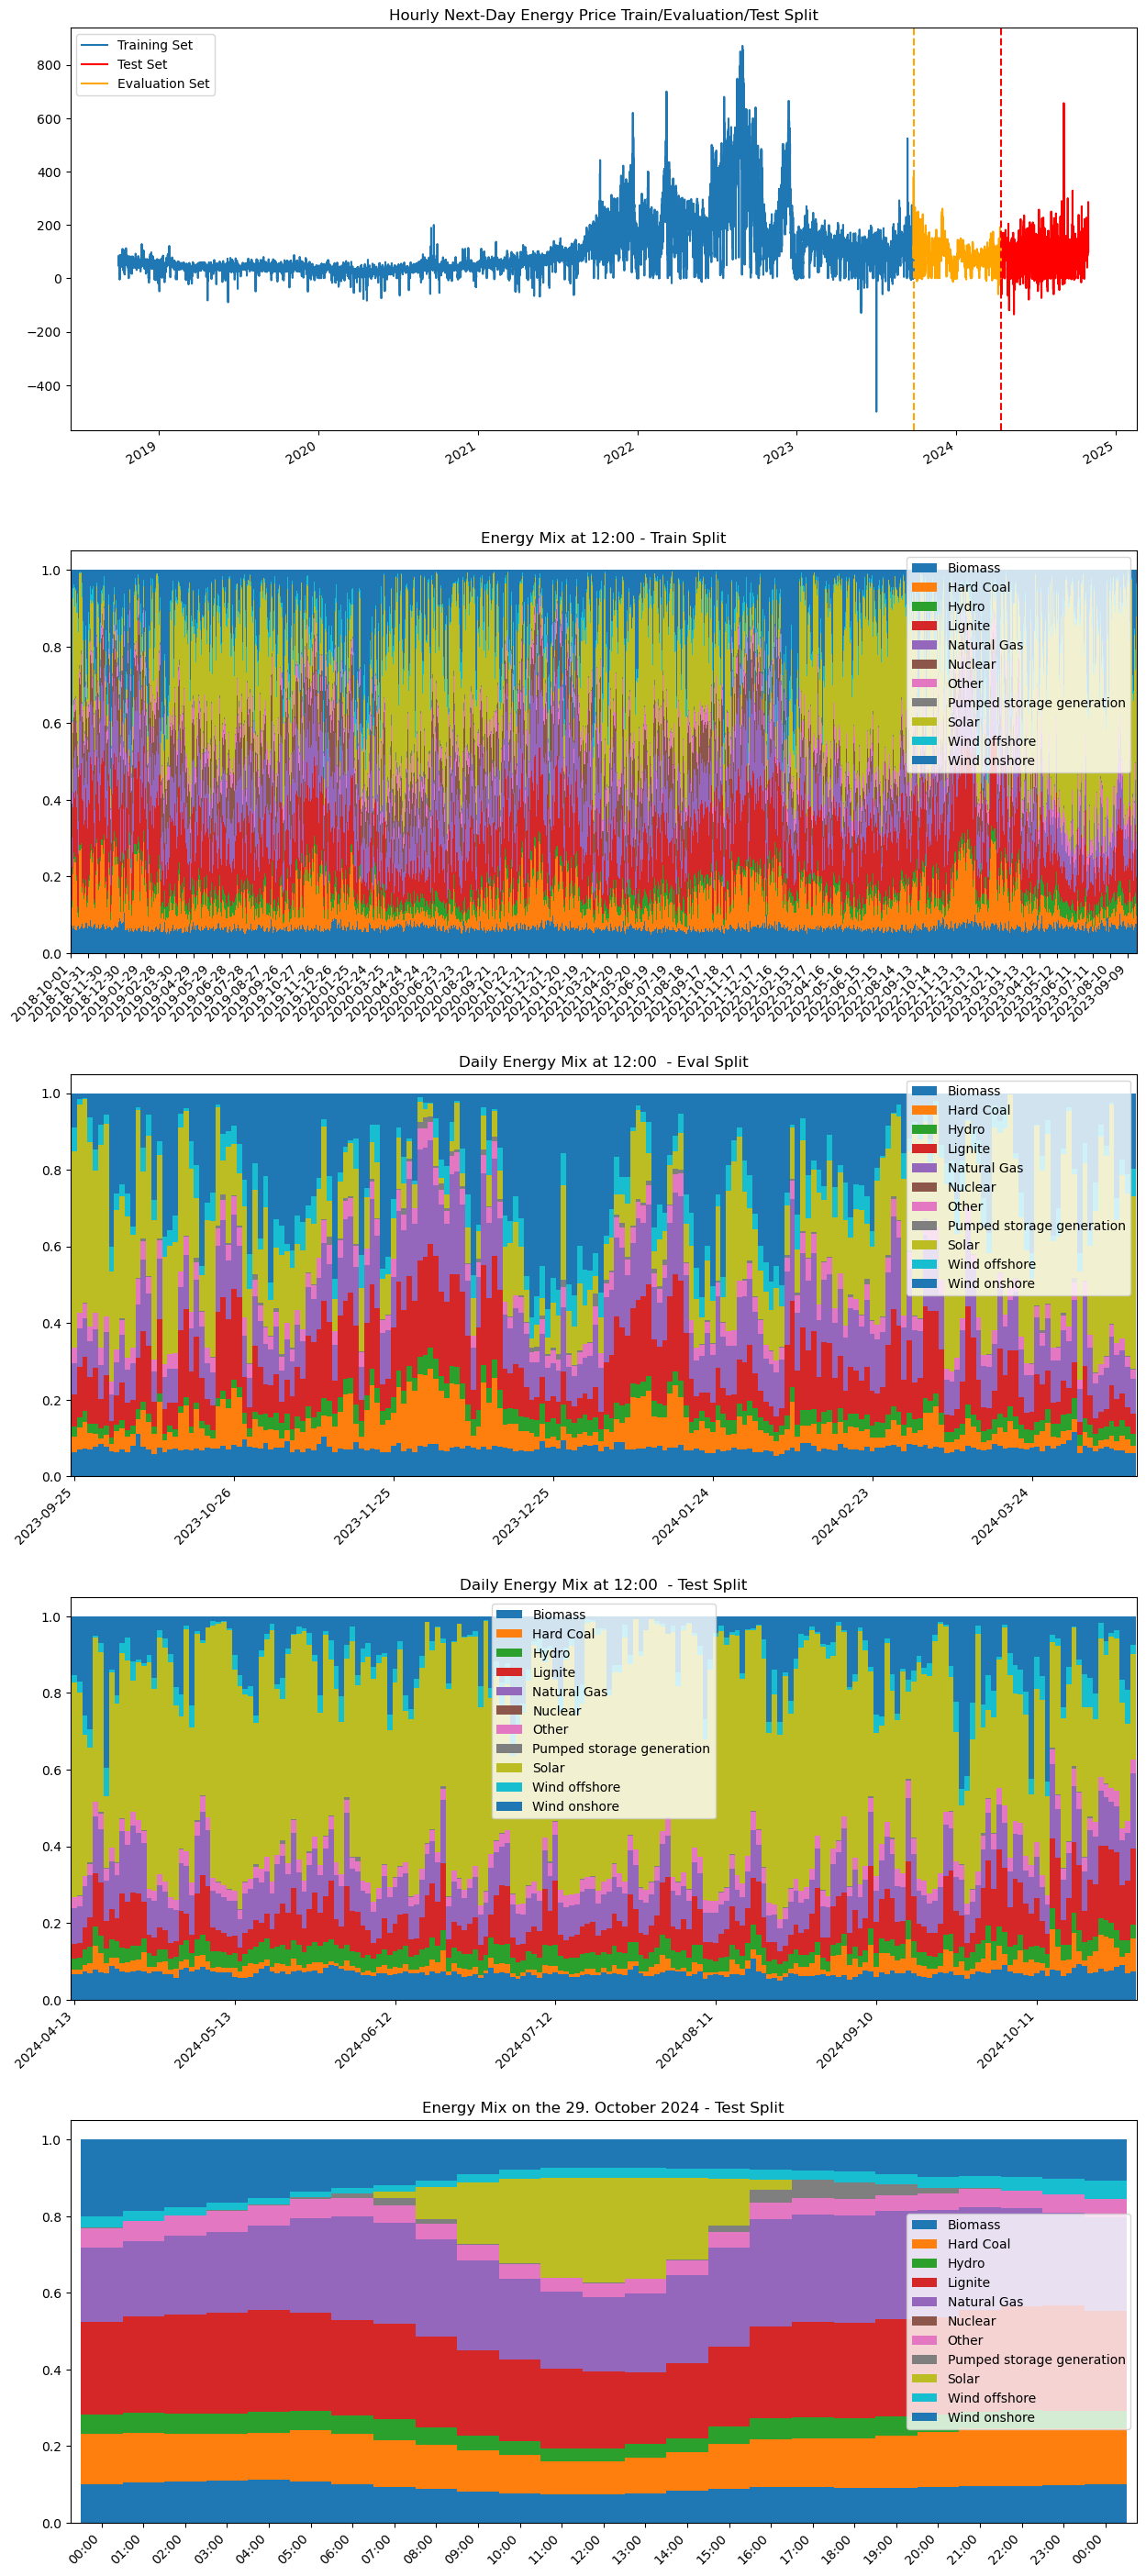

In [9]:
fig, axs = plt.subplots(nrows=5, figsize=(15, 40))
train["Price"].plot(ax=axs[0], label='Training Set', title='Hourly Next-Day Energy Price Train/Evaluation/Test Split')
test["Price"].plot(ax=axs[0], label='Test Set', color="red")
eval["Price"].plot(ax=axs[0], label='Evaluation Set', color="orange")
axs[0].axvline(SPLIT_DATE_EVAL, color='orange', ls='--')
axs[0].axvline(SPLIT_DATE_TEST, color='red', ls='--')
axs[0].legend(['Training Set', 'Test Set', 'Evaluation Set'])


cols = [
    "Biomass",
    "Hard Coal",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore"
    ]

filtered_train = train[train.index.hour == 12][::-1]
filtered_train[cols].plot(ax=axs[1], kind="bar", stacked=True, title='Energy Mix at 12:00 - Train Split', width=1.0)
axs[1].set_xticks(np.arange(0, len(filtered_train), 30))
axs[1].set_xticklabels(filtered_train.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_eval = eval[eval.index.hour == 12][::-1]
filtered_eval[cols].plot(ax=axs[2], kind="bar", stacked=True, title='Daily Energy Mix at 12:00  - Eval Split', width=1.0)
axs[2].set_xticks(np.arange(0, len(filtered_eval), 30))
axs[2].set_xticklabels(filtered_eval.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_test = test[test.index.hour == 12][::-1]
filtered_test[cols].plot(ax=axs[3], kind="bar", stacked=True, title='Daily Energy Mix at 12:00  - Test Split', width=1.0)
axs[3].set_xticks(np.arange(0, len(filtered_test), 30))
axs[3].set_xticklabels(filtered_test.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_test = test.head(25)[::-1]
# print(filtered_test)
filtered_test[cols].plot(ax=axs[4], kind="bar", stacked=True, title='Energy Mix on the 29. October 2024 - Test Split', width=1.0)
axs[4].set_xticks(np.arange(0, len(filtered_test), 1))
axs[4].set_xticklabels(filtered_test.index.strftime('%H:%M'), rotation=45, ha='right')

plt.subplots_adjust(hspace=0.3)
plt.show()


## Feature Selection

In [10]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
        df[f'lignite_ma_{int(window)}_hours'] = df["Lignite"].rolling(window=window).mean()
        df[f'natural_gas_ma_{int(window)}_hours'] = df["Natural Gas"].rolling(window=window).mean()
        df[f'nuclear_ma_{int(window)}_hours'] = df["Nuclear"].rolling(window=window).mean()
        df[f'other_ma_{int(window)}_hours'] = df[ "Other"].rolling(window=window).mean()
        df[f'solar_ma_{int(window)}_hours'] = df['Solar'].rolling(window=window).mean()
        df[f'wind_offshore_ma_{int(window)}_hours'] = df["Wind offshore"].rolling(window=window).mean()
        df[f'wind_onshore_ma_{int(window)}_hours'] = df["Wind onshore"].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    return df

In [11]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",

    "ma_3_hours",
    "ma_6_hours",   
    "ma_1_days",
    # "ma_3_days",
    "ma_7_days",

# -- Energy Mix --
    "Biomass",
    "Hard Coal",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",

    # "biomass_ma_3_hours",
    # "biomass_ma_6_hours",
    # "biomass_ma_1_days",
    # "biomass_ma_3_days",
    # "biomass_ma_7_days",

    "pumped_storage_generation_ma_3_hours",
    "pumped_storage_generation_ma_6_hours",
    # "pumped_storage_generation_ma_1_days",
    # "pumped_storage_generation_ma_3_days",
    # "pumped_storage_generation_ma_7_days",
   
    # "hard_coal_ma_3_hours",
    # "hard_coal_ma_6_hours",
    # "hard_coal_ma_1_days",
    # "hard_coal_ma_3_days",
    # "hard_coal_ma_7_days",

    # "lignite_ma_3_hours",
    # "lignite_ma_6_hours",

    # "natural_gas_ma_3_hours",
    # "natural_gas_ma_6_hours",

    # "nuclear_ma_3_hours",
    # "nuclear_ma_6_hours",

    # "other_ma_3_hours",
    # "other_ma_6_hours",

    # "solar_ma_3_hours",
    # "solar_ma_6_hours",

    # "wind_offshore_ma_3_hours",
    # "wind_offshore_ma_6_hours",

    # "wind_onshore_ma_3_hours",
    # "wind_onshore_ma_6_hours",


#  -- Predicted Weather -- 
    # "pred_temperature_2m",
    # "pred_temperature_2m_previous_day1",
    # "pred_temperature_2m_previous_day2",
    # "pred_temperature_2m_previous_day3",
    # "pred_temperature_2m_previous_day4",
    # "pred_temperature_2m_previous_day5",
    # "pred_temperature_2m_previous_day6",
    # "pred_temperature_2m_previous_day7",
    # "pred_relative_humidity_2m",
    # "pred_relative_humidity_2m_previous_day1",
    # "pred_relative_humidity_2m_previous_day2",
    # "pred_relative_humidity_2m_previous_day3",
    # "pred_relative_humidity_2m_previous_day4",
    # "pred_relative_humidity_2m_previous_day5",
    # "pred_relative_humidity_2m_previous_day6",
    # "pred_relative_humidity_2m_previous_day7",
    # "pred_precipitation",
    # "pred_precipitation_previous_day1",
    # "pred_precipitation_previous_day2",
    # "pred_precipitation_previous_day3",
    # "pred_precipitation_previous_day4",
    # "pred_precipitation_previous_day5",
    # "pred_precipitation_previous_day6",
    # "pred_precipitation_previous_day7",
    # "pred_surface_pressure",
    # "pred_surface_pressure_previous_day1",
    # "pred_surface_pressure_previous_day2",
    # "pred_surface_pressure_previous_day3",
    # "pred_surface_pressure_previous_day4",
    # "pred_surface_pressure_previous_day5",
    # "pred_surface_pressure_previous_day7",
    # "pred_shortwave_radiation",
    # "pred_shortwave_radiation_previous_day1",
    # "pred_shortwave_radiation_previous_day2",
    # "pred_shortwave_radiation_previous_day3",
    # "pred_shortwave_radiation_previous_day4",
    # "pred_shortwave_radiation_previous_day5",
    # "pred_shortwave_radiation_previous_day6",
    # "pred_shortwave_radiation_previous_day7",
    # "pred_wind_speed_80m",
    # "pred_wind_speed_80m_previous_day1",
    # "pred_wind_speed_80m_previous_day2",
    # "pred_wind_speed_80m_previous_day3",
    # "pred_wind_speed_80m_previous_day4",
    # "pred_wind_speed_80m_previous_day5",
    # "pred_wind_speed_80m_previous_day6",
    # "pred_wind_speed_80m_previous_day7",

 #  -- Actual Weather -- 
    # "temperature_2m",
    # "relative_humidity_2m",
    # "precipitation",
    # "surface_pressure",
    # "cloud_cover",
    # "wind_speed_100m",
    # "sunshine_duration",
    # "shortwave_radiation",
    # "direct_radiation",
]

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

## Auto ML

In [12]:
def model_fit_and_predict(params, 
                          X_train_local, y_train_local, 
                          X_val_local, y_val_local, 
                          X_test_local, y_test_local):
    reg = xgb.XGBRegressor(**params)
    reg.fit(X_train_local, y_train_local, eval_set=[(X_val_local, y_val_local)], verbose=None)
    pred = reg.predict(X_test_local)
    score = root_mean_squared_error(y_test_local, pred)
    return score


model_fit_and_predict

<function __main__.model_fit_and_predict(params, X_train_local, y_train_local, X_val_local, y_val_local, X_test_local, y_test_local)>

In [ ]:

def objective(search_space):
    # Hyperoptで得たパラメータをXGBoost用に整形
    params = {
        "base_score": 0.380924762889507,
        "max_depth": int(search_space["max_depth"]),
        "learning_rate": float(search_space["learning_rate"]),
        "n_estimators": int(search_space["n_estimators"]),
        "gamma": float(search_space["gamma"]),
        "min_child_weight": int(search_space["min_child_weight"]),
        "subsample": float(search_space["subsample"]),
        "colsample_bytree": float(search_space["colsample_bytree"]),
        # 早期打ち切りのパラメータはfit時に指定
        "early_stopping": 20,  # 必要ならここも探索可能
    }

    rmse = model_fit_and_predict(params, 
                                 X_train_scaled, y_train, 
                                 X_val_scaled, y_val, 
                                 X_test_scaled, y_test)
    return rmse

In [14]:
# スケーラーのインスタンスを作成
scaler = StandardScaler()

# 学習用データでスケーラーをフィットし、学習用データを変換
X_train_scaled = scaler.fit_transform(X_train)

# テスト・評価用データを同じスケーラーで変換（フィットはしない）
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [19]:
search = True

# 複数パラメータ探索用search_space
search_space = {
    "max_depth": hp.choice("max_depth", np.arange(5, 51, 1, dtype=int)),          # max_depthを5~50まで
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.1),                    # 学習率0.01~0.1
    "n_estimators": hp.choice("n_estimators", np.arange(50, 500, 10, dtype=int)),# 50~500まで10刻み
    "gamma": hp.uniform("gamma", 0, 2.0),                                        # gammaを0~2
    "min_child_weight": hp.choice("min_child_weight", np.arange(1, 10, 1, dtype=int)), # 1~9
    "subsample": hp.uniform("subsample", 0.5, 1.0),                              # subsample 0.5~1.0
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),                # colsample_bytree 0.5~1.0
}

trials = Trials()
best_search = {}
if search:
    best_search = fmin(
        fn=objective, 
        space=search_space, 
        algo=tpe.suggest,
        max_evals=50,  # 試行回数を増やしてみる
        trials=trials
    )

    # Hyperoptはindexを返す場合があるため、対応する実際の値を取得
    max_depth_value = np.arange(5, 51, 1, dtype=int)[best_search["max_depth"]]
    n_estimators_value = np.arange(50, 500, 10, dtype=int)[best_search["n_estimators"]]
    min_child_weight_value = np.arange(1, 10, 1, dtype=int)[best_search["min_child_weight"]]

    # best_params内からearly_stoppingを削除
best_params = {
    "base_score": 0.380924762889507,
    "max_depth": int(max_depth_value),
    "learning_rate": float(best_search["learning_rate"]),
    "n_estimators": int(n_estimators_value),
    "gamma": float(best_search["gamma"]),
    "min_child_weight": int(min_child_weight_value),
    "subsample": float(best_search["subsample"]),
    "colsample_bytree": float(best_search["colsample_bytree"]),
}

print("Optimized Parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

reg = xgb.XGBRegressor(**best_params)
reg.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=25,
    )  

test['prediction'] = reg.predict(X_test_scaled)
score = root_mean_squared_error(y_test, test['prediction'])
print(f'RMSE Score on Test set: {score:.6f}')

100%|██████████| 50/50 [09:03<00:00, 10.87s/trial, best loss: 10.570014220709778]
Optimized Parameters:
base_score: 0.380924762889507
max_depth: 10
learning_rate: 0.05683178615933138
n_estimators: 160
gamma: 0.020870301460889307
min_child_weight: 8
subsample: 0.7913580511579683
colsample_bytree: 0.9743751443437378
[0]	validation_0-rmse:79.83875
[25]	validation_0-rmse:20.41017
[50]	validation_0-rmse:8.73207
[75]	validation_0-rmse:7.33908
[100]	validation_0-rmse:7.16670
[125]	validation_0-rmse:7.06495
[150]	validation_0-rmse:7.00812
[159]	validation_0-rmse:6.99639
RMSE Score on Test set: 10.568321


## Final Model

In [20]:
best_params = {
    "base_score": 0.380924762889507,
    "max_depth": 9,
    "learning_rate": 0.07865882273189834,
    "n_estimators": 150,
    "gamma": 1.970416112280022,
    "min_child_weight": 6,
    "subsample": 0.9303326759378288,
    "colsample_bytree": 0.9531733385294373,
}


reg = xgb.XGBRegressor(**best_params)

reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=25)

test['prediction'] = reg.predict(X_test)
score = root_mean_squared_error(y_test, test['prediction'])
print(f'RMSE Score on Test set: {score:.6f}')

[0]	validation_0-rmse:77.97461
[25]	validation_0-rmse:13.00045
[50]	validation_0-rmse:7.53007
[75]	validation_0-rmse:7.21234
[100]	validation_0-rmse:7.05963
[125]	validation_0-rmse:6.97035
[149]	validation_0-rmse:6.96210
RMSE Score on Test set: 10.498889


### Results

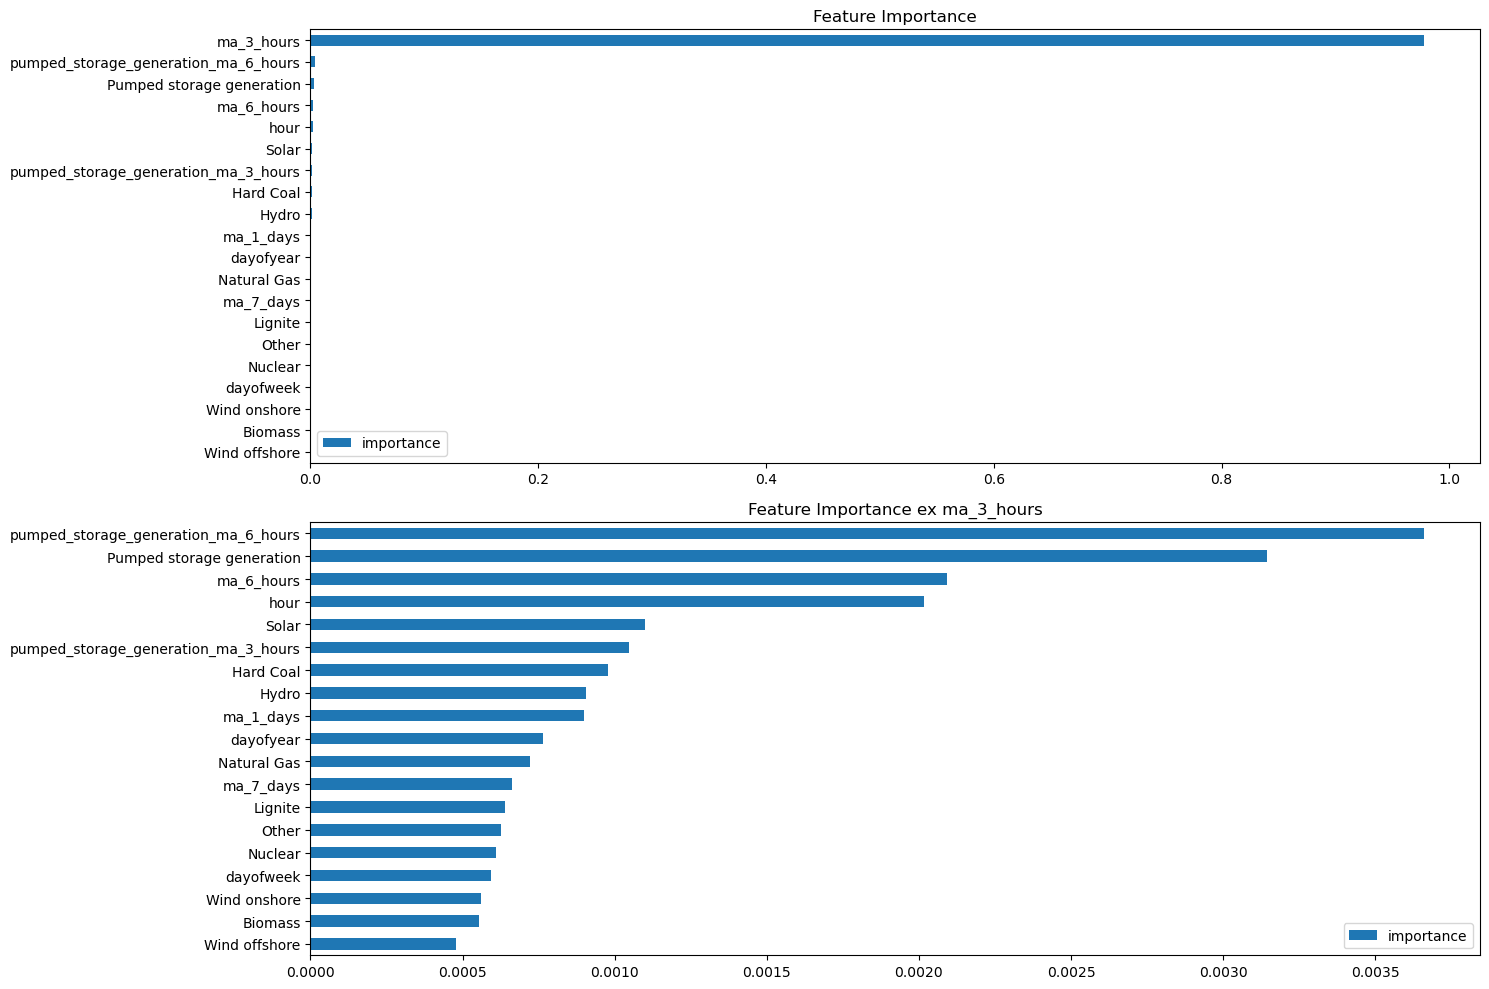

In [21]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

idx = np.argsort(reg.feature_importances_)[::-1]
fi_sorted = reg.feature_importances_[idx]
fn_sorted = reg.feature_names_in_[idx]
idx_limited = np.argsort(reg.feature_importances_)[::-1][1:]
fi_sorted_limited = reg.feature_importances_[idx_limited]
fn_sorted_limited = reg.feature_names_in_[idx_limited]

fi = pd.DataFrame(data=fi_sorted,
             index=fn_sorted,
             columns=['importance'], )
fi.sort_values('importance').plot(ax=axs[0], kind='barh', title='Feature Importance')
fi = pd.DataFrame(data=fi_sorted_limited,
             index=fn_sorted_limited,
             columns=['importance'], )
fi.sort_values('importance').plot(ax=axs[1], kind='barh', title='Feature Importance ex ma_3_hours')
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

feature_importance_image = Image.open(buf)

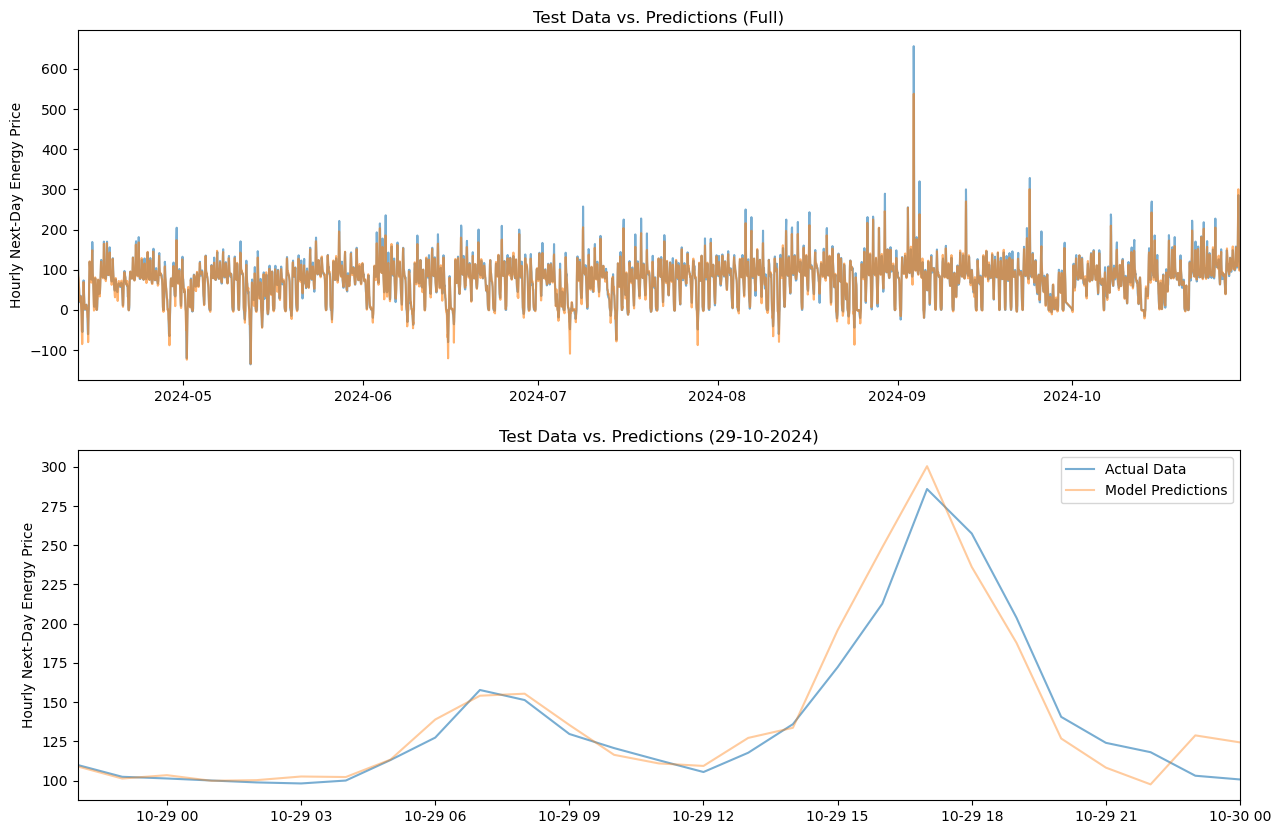

In [22]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

WINDOW = test.copy()


axs[0].plot(WINDOW.index, WINDOW[TARGET],  alpha=0.6)
axs[0].plot(WINDOW.index, WINDOW["prediction"],  alpha=0.6)
axs[0].set_xlim(WINDOW.index.min(), WINDOW.index.max())
axs[0].set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
axs[0].set_title('Test Data vs. Predictions (Full)')

WINDOW = test["2024-10-28 22:00:00":].copy()
axs[1].plot(WINDOW.index, WINDOW[TARGET],  alpha=0.6)
axs[1].plot(WINDOW.index, WINDOW["prediction"],  alpha=0.4)
axs[1].set_xlim(WINDOW.index.min(), WINDOW.index.max())
axs[1].set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
axs[1].set_title('Test Data vs. Predictions (29-10-2024)')

buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

ts_image = Image.open(buf)

### Specific Date Predictions

In [23]:
date = '2024-10-29'
predictions = test.loc[date, 'prediction']

# Display the result
print(predictions)

2024-10-29 23:00:00    128.799194
2024-10-29 22:00:00     97.584450
2024-10-29 21:00:00    108.249916
2024-10-29 20:00:00    126.816727
2024-10-29 19:00:00    187.813431
2024-10-29 18:00:00    236.138718
2024-10-29 17:00:00    300.341949
2024-10-29 16:00:00    248.718582
2024-10-29 15:00:00    195.821213
2024-10-29 14:00:00    133.639099
2024-10-29 13:00:00    127.191597
2024-10-29 12:00:00    109.335541
2024-10-29 11:00:00    110.932098
2024-10-29 10:00:00    116.409523
2024-10-29 09:00:00    135.433945
2024-10-29 08:00:00    155.364975
2024-10-29 07:00:00    154.077194
2024-10-29 06:00:00    138.899734
2024-10-29 05:00:00    113.359756
2024-10-29 04:00:00    102.259300
2024-10-29 03:00:00    102.597672
2024-10-29 02:00:00    100.266312
2024-10-29 01:00:00     99.850021
2024-10-29 00:00:00    103.444344
Name: prediction, dtype: float32


### Average absolute error by day

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test['error'].groupby(test['date']).mean()

date
2024-04-12    10.289248
2024-04-13    10.762043
2024-04-14     7.006701
2024-04-15     8.346428
2024-04-16     4.806679
                ...    
2024-10-26     5.255698
2024-10-27     6.485802
2024-10-28     4.107827
2024-10-29    10.199706
2024-10-30    23.622893
Name: error, Length: 202, dtype: float64

## Persisting Current Model and Features

In [25]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./pickle/model_{score: .7g}_rmse_{ts}'
os.makedirs(output_dir, exist_ok=True)

model_dump_path = os.path.join(output_dir, "model.pickle")
with open(model_dump_path, "wb") as file:
    pickle.dump(reg, file)
hp_path = os.path.join(output_dir, "hyperparams.json")
with open(hp_path, "w") as file:
    best_params_native = {k: (int(v) if isinstance(v, (np.integer, int)) else float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_params.items()}
    json.dump(best_params_native, file, indent=4)
output_filename = 'plot_image.png'
ts_chart_path = os.path.join(output_dir, output_filename)
ts_image.save(ts_chart_path)

output_filename = 'feature_importance.png'
fi_path = os.path.join(output_dir, output_filename)
feature_importance_image.save(fi_path)